In [ ]:
from tensorflow.keras import utils
from tensorflow import keras
import os
import glob
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import albumentations as A
import albumentations.augmentations.functional as F
from tqdm import tqdm


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

root = os.path.join('/content/drive/MyDrive/Data')
images_directory = os.path.join(root, 'image_dataset')
masks_directory = os.path.join(root, 'mask_dataset')


Size = 256
        

In [ ]:
# img_names = glob.glob('/content/drive/MyDrive/Data/image_dataset/*.jpg')
# msk_names = glob.glob('/content/drive/MyDrive/Data/mask_dataset/*.png')


In [ ]:
# img_names.sort()
# msk_names.sort()

In [ ]:
def preprocess_mask(mask):
    #mask = mask.astype(np.int32)
    #mask[mask != 3] = 0
    mask[ (mask == 0) | (mask == 1) | (mask == 3) | (mask == 4) | (mask == 5) | (mask == 8) | (mask == 10)
     | (mask == 11) | (mask == 13) | (mask == 14) | (mask == 15) | (mask == 16) | (mask == 17) | (mask == 18) | (mask == 19) | (mask == 20)
      | (mask == 21) | (mask == 23) | (mask == 24)] = 0
    mask[mask == 2] = 1 # grass
    mask[mask == 9] = 2 # dog
    mask[mask == 6] = 3 # tree
    mask[mask == 7] = 4 # sky
    mask[ (mask == 12) | (mask == 22)] = 5 # ball
    
    return mask

In [ ]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:266]
val_images_filenames = correct_images_filenames[266:-10]
test_images_filenames = images_filenames[-10:]


In [ ]:
# !pip install -U albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-53_ftern
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-53_ftern


In [ ]:
import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [ ]:
# class_names = ['background','ball','grass','person','tree','sky','building','dog','house','car',
#                     'concrete','dirt','rock','vase','wood','cat','wall','water','hose','hose_machine',
#                     'walkway','mountain','pole','garbage_can']
# class_rgb_values = [
#                     [0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],[128,0,128],[0,128,128],
#                     [128,128,128],[64,0,0],[192,0,0],[64,128,0],[192,128,0],[64,0,128],[192,0,128],
#                     [64,128,128],[192,128,128],[0,64,0],[128,64,0],[0,192,0],[128,192,0],[0,64,128],
#                     [128,64,128],[0,192,128],[128,192,128]
#                     ]

In [ ]:
select_classes = ['grass', 'dog', 'tree', 'sky', 'ball', 'background']

In [ ]:
def visualize(**images):
    """
    Plot images in one row
    """
    
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [ ]:

class BackgroundDataset:

    CLASSES = ['grass', 'dog', 'tree', 'sky', 'ball', 'background']

    
    def __init__(
            self, 
            images_filenames,
            images_directory,
            masks_directory,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
        )
        mask = preprocess_mask(mask)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_filenames)

In [ ]:
class Dataloder(utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

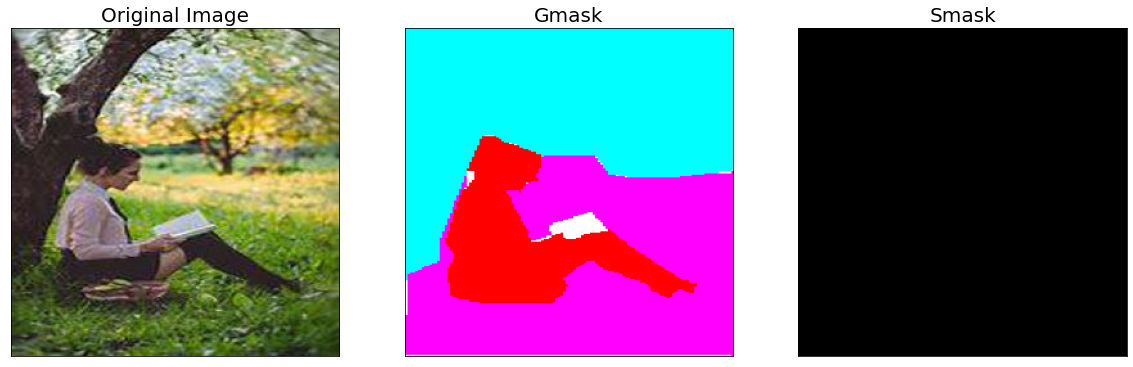

In [ ]:
dataset = BackgroundDataset(images_filenames, images_directory, masks_directory, classes=['grass', 'sky'])
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[20]

visualize(
    original_image = image,
    gmask=mask[..., 0].squeeze()
    
)

In [ ]:
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=256, min_width=256, border_mode=4), A.Resize(256, 256),]
)

train_transform = A.Compose(
    [
        #A.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
        A.Resize(256, 256),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [ ]:
# def round_clip_0_1(x, **kwargs):
#     return x.round().clip(0, 1)

# # define heavy augmentations
# def get_training_augmentation():
#     train_transform = [

#         A.HorizontalFlip(p=0.5),

#         A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         # A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         # A.RandomCrop(height=320, width=320, always_apply=True),

#         A.IAAAdditiveGaussianNoise(p=0.2),
#         A.IAAPerspective(p=0.5),

#         A.OneOf(
#             [
#                 A.CLAHE(p=1),
#                 A.RandomBrightness(p=1),
#                 A.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         A.OneOf(
#             [
#                 A.IAASharpen(p=1),
#                 A.Blur(blur_limit=3, p=1),
#                 A.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         A.OneOf(
#             [
#                 A.RandomContrast(p=1),
#                 A.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
#         A.Lambda(mask=round_clip_0_1)
#     ]
#     return A.Compose(train_transform)


# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         A.PadIfNeeded(384, 480)
#     ]
#     return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
augmented_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory, classes=select_classes,
    augmentation=train_transform
)

image, mask = augmented_dataset[15] # get some sample
# visualize(
#     image=image, 
#     mask=mask[..., 0].squeeze(),
# )

In [ ]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null

!pip install segmentation_models

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
# import segmentation_models_pytorch as smp

In [ ]:
BACKBONE = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
activation = 'softmax' # or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = sm.Unet(
    BACKBONE , 
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES), 
    activation=activation
)

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# Get train and val dataset instances
train_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory, 
    classes=select_classes, augmentation=train_transform,
    preprocessing=get_preprocessing(preprocess_input),
    
)

valid_dataset = BackgroundDataset(
    val_images_filenames, images_directory, masks_directory, 
    classes=select_classes, 
    preprocessing=get_preprocessing(preprocess_input)
    
)

# Get train and val data loaders
train_loader = Dataloder(train_dataset, batch_size=4, shuffle=True)
valid_loader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
# define optomizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)
weights = [0.1666, 0.1666,0.1666,0.1666,0.1666,0.1666]
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.ones(6))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# np.argmax(train_labels, axis=1)
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# check shapes for errors
assert train_dataloader[0][0].shape == (4, 256, 256, 3)
assert train_dataloader[0][1].shape == (4, 256, 256, 6)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Data/best_GRASS_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
EPOCHS = 40

history = model.fit(
    train_loader, 
    steps_per_epoch=len(train_loader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_loader, 
    validation_steps=len(valid_loader)
)

Epoch 1/40


InvalidArgumentError: ignored

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BackgroundDataset_Test(
    test_images_filenames, images_directory, masks_directory,
    classes = select_classes,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_input),
    
)

test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = BackgroundDataset_Test(
    test_images_filenames, images_directory, masks_directory,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [ ]:
sample_preds_folder = '/content/drive/MyDrive/Data/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    #pred_mask = best_model(x_tensor)
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # from CHW format to HWC format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        
    )

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model = model,
    # model = best_model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

In [ ]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()